# Import Library

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.transforms as mtransforms
import datetime
import math

# Fred Data

In [2]:
def gather_data(data_codes, start, 
                end = datetime.datetime.today(), freq = "M"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

In [3]:
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR",
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
               }
               
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
fed_data = gather_data(data_codes = data_codes, start = start, 
                   end = end, freq = "M")

# Load Data

In [4]:
data=pd.read_csv("data 1.csv")

In [5]:
data

,Date,Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),Effective Federal Funds Rate,Adj Close,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
0,1/31/2000,594.68,0.00,5.45,1394.46,0.000000,0.000000,7.240263,4.1
1,2/29/2000,566.14,0.00,5.73,1366.42,0.000000,0.000000,7.219949,4.0
2,3/31/2000,563.71,0.00,5.85,1498.58,0.000000,0.000000,7.312273,3.8
3,4/30/2000,564.73,0.00,6.02,1452.43,0.000000,1.000000,7.280993,4.0
4,5/31/2000,565.84,0.00,6.27,1420.60,0.000000,0.000000,7.258835,4.0
...,...,...,...,...,...,...,...,...,...
257,6/30/2021,2178.84,8026555.20,0.08,4297.50,15.898266,0.000271,8.365789,5.4
258,7/31/2021,2186.13,8190356.75,0.10,4395.26,15.918468,0.000267,8.388282,5.2
259,8/31/2021,2187.63,8291893.25,0.09,4522.68,15.930789,0.000264,8.416860,4.8
260,9/30/2021,2194.90,8418612.40,0.08,4307.54,15.945956,0.000261,8.368122,4.6


In [6]:
data.dtypes

Date                                      object
Base: Currency in Circulation ($ Mil)    float64
Balance Sheet: Total Assets ($ Mil)      float64
Effective Federal Funds Rate             float64
Adj Close                                float64
Log Total Asset                          float64
Currency in Circulation/Total Asset      float64
Log Stock Price                          float64
Unemployment Rate                        float64
dtype: object

In [7]:
data = data.set_index('Date')

In [8]:
data

,Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),Effective Federal Funds Rate,Adj Close,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,,,,
1/31/2000,594.68,0.00,5.45,1394.46,0.000000,0.000000,7.240263,4.1
2/29/2000,566.14,0.00,5.73,1366.42,0.000000,0.000000,7.219949,4.0
3/31/2000,563.71,0.00,5.85,1498.58,0.000000,0.000000,7.312273,3.8
4/30/2000,564.73,0.00,6.02,1452.43,0.000000,1.000000,7.280993,4.0
5/31/2000,565.84,0.00,6.27,1420.60,0.000000,0.000000,7.258835,4.0
...,...,...,...,...,...,...,...,...
6/30/2021,2178.84,8026555.20,0.08,4297.50,15.898266,0.000271,8.365789,5.4
7/31/2021,2186.13,8190356.75,0.10,4395.26,15.918468,0.000267,8.388282,5.2
8/31/2021,2187.63,8291893.25,0.09,4522.68,15.930789,0.000264,8.416860,4.8


In [9]:
data_new = data.drop(['Base: Currency in Circulation ($ Mil)', 'Balance Sheet: Total Assets ($ Mil)', 'Adj Close'], axis=1)

In [10]:
data_new

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,
1/31/2000,5.45,0.000000,0.000000,7.240263,4.1
2/29/2000,5.73,0.000000,0.000000,7.219949,4.0
3/31/2000,5.85,0.000000,0.000000,7.312273,3.8
4/30/2000,6.02,0.000000,1.000000,7.280993,4.0
5/31/2000,6.27,0.000000,0.000000,7.258835,4.0
...,...,...,...,...,...
6/30/2021,0.08,15.898266,0.000271,8.365789,5.4
7/31/2021,0.10,15.918468,0.000267,8.388282,5.2
8/31/2021,0.09,15.930789,0.000264,8.416860,4.8


In [11]:
data_new = data_new.loc['1/31/2009':'10/31/2021']

In [12]:
data_new

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,
1/31/2009,0.15,14.525435,0.000436,6.716449,8.3
2/28/2009,0.22,14.447648,0.000475,6.599993,8.7
3/31/2009,0.18,14.501045,0.000454,6.681946,9.0
4/30/2009,0.15,14.568579,0.000425,6.771718,9.4
5/31/2009,0.18,14.573726,0.000424,6.823438,9.5
...,...,...,...,...,...
6/30/2021,0.08,15.898266,0.000271,8.365789,5.4
7/31/2021,0.10,15.918468,0.000267,8.388282,5.2
8/31/2021,0.09,15.930789,0.000264,8.416860,4.8


In [13]:
data_new.columns

Index(['Effective Federal Funds Rate', 'Log Total Asset',
       'Currency in Circulation/Total Asset', 'Log Stock Price',
       'Unemployment Rate'],
      dtype='object')

In [14]:
data_new.diff()

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,
1/31/2009,NaN,NaN,NaN,NaN,NaN
2/28/2009,0.07,-0.077786,0.000039,-0.116457,0.4
3/31/2009,-0.04,0.053397,-0.000021,0.081953,0.3
4/30/2009,-0.03,0.067534,-0.000028,0.089772,0.4
5/31/2009,0.03,0.005147,-0.000001,0.051721,0.1
...,...,...,...,...,...
6/30/2021,0.02,0.020092,-0.000004,0.021971,-0.5
7/31/2021,0.02,0.020202,-0.000005,0.022493,-0.2
8/31/2021,-0.01,0.012321,-0.000003,0.028578,-0.4


In [15]:
data_stock =  data_new.diff()

In [16]:
data_stock

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,
1/31/2009,NaN,NaN,NaN,NaN,NaN
2/28/2009,0.07,-0.077786,0.000039,-0.116457,0.4
3/31/2009,-0.04,0.053397,-0.000021,0.081953,0.3
4/30/2009,-0.03,0.067534,-0.000028,0.089772,0.4
5/31/2009,0.03,0.005147,-0.000001,0.051721,0.1
...,...,...,...,...,...
6/30/2021,0.02,0.020092,-0.000004,0.021971,-0.5
7/31/2021,0.02,0.020202,-0.000005,0.022493,-0.2
8/31/2021,-0.01,0.012321,-0.000003,0.028578,-0.4


In [17]:
data_updated = data_stock.dropna()

In [18]:
data_updated

,Effective Federal Funds Rate,Log Total Asset,Currency in Circulation/Total Asset,Log Stock Price,Unemployment Rate
Date,,,,,
2/28/2009,0.07,-0.077786,0.000039,-0.116457,0.4
3/31/2009,-0.04,0.053397,-0.000021,0.081953,0.3
4/30/2009,-0.03,0.067534,-0.000028,0.089772,0.4
5/31/2009,0.03,0.005147,-0.000001,0.051721,0.1
6/30/2009,0.03,-0.036956,0.000017,0.000196,0.0
...,...,...,...,...,...
6/30/2021,0.02,0.020092,-0.000004,0.021971,-0.5
7/31/2021,0.02,0.020202,-0.000005,0.022493,-0.2
8/31/2021,-0.01,0.012321,-0.000003,0.028578,-0.4


In [19]:
data_updated.isnull().sum()

Effective Federal Funds Rate           0
Log Total Asset                        0
Currency in Circulation/Total Asset    0
Log Stock Price                        0
Unemployment Rate                      0
dtype: int64

# Build Model

In [20]:
X = data_updated.drop('Log Stock Price', axis = 1)
Y = data_updated[['Log Stock Price']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)


regression_model = LinearRegression()


regression_model.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

LinearRegression()

# Exploring the Output

In [21]:
# let's grab the coefficient of our model and the intercept
intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 0.01259
----------------------------------------------------------------------------------------------------
The Coefficient for Effective Federal Funds Rate is -0.016
The Coefficient for Log Total Asset is -0.62
The Coefficient for Currency in Circulation/Total Asset is -2.9e+03
The Coefficient for Unemployment Rate is -0.019


# Evaluating the Model

In [22]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

In [23]:
# Get multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[ 0.01504395],
       [-0.00394883],
       [ 0.00721112],
       [ 0.00850784],
       [ 0.01014888]])

In [24]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

## Checking for Heteroscedasticity

In [25]:
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity.")

0.3512441342490251 0.3576171816128195
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 0.3512
We fail to reject the null hypthoesis, so there is no heterosecdasticity.


# Checking for Autocorrelation

The number of lags will be 10
----------------------------------------------------------------------------------------------------
The lowest p-value found was 0.1065
We fail to reject the null hypthoesis, so there is no autocorrelation.
----------------------------------------------------------------------------------------------------


C:\Users\JLCat\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


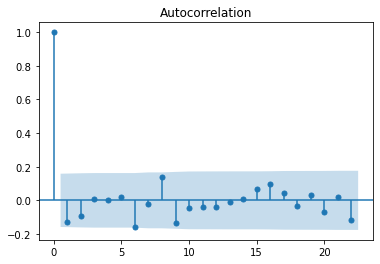

In [26]:
# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

### OLS

In [27]:
y_var = ["Log Stock Price"]
x_vars = ["Log Total Asset",
         "Currency in Circulation/Total Asset",
         "Effective Federal Funds Rate",
         "Unemployment Rate"]
reg_vars = y_var + x_vars
reg_data = data[reg_vars].dropna()
reg_data

,Log Stock Price,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate
Date,,,,,
1/31/2000,7.240263,0.000000,0.000000,5.45,4.1
2/29/2000,7.219949,0.000000,0.000000,5.73,4.0
3/31/2000,7.312273,0.000000,0.000000,5.85,3.8
4/30/2000,7.280993,0.000000,1.000000,6.02,4.0
5/31/2000,7.258835,0.000000,0.000000,6.27,4.0
...,...,...,...,...,...
6/30/2021,8.365789,15.898266,0.000271,0.08,5.4
7/31/2021,8.388282,15.918468,0.000267,0.10,5.2
8/31/2021,8.416860,15.930789,0.000264,0.09,4.8


In [28]:
reg_data.corr()

,Log Stock Price,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate
Log Stock Price,1.000000,0.379568,-0.204783,-0.193854,-0.311260
Log Total Asset,0.379568,1.000000,-0.560952,-0.555311,0.235350
Currency in Circulation/Total Asset,-0.204783,-0.560952,1.000000,0.147557,-0.077404
Effective Federal Funds Rate,-0.193854,-0.555311,0.147557,1.000000,-0.561607
Unemployment Rate,-0.311260,0.235350,-0.077404,-0.561607,1.000000


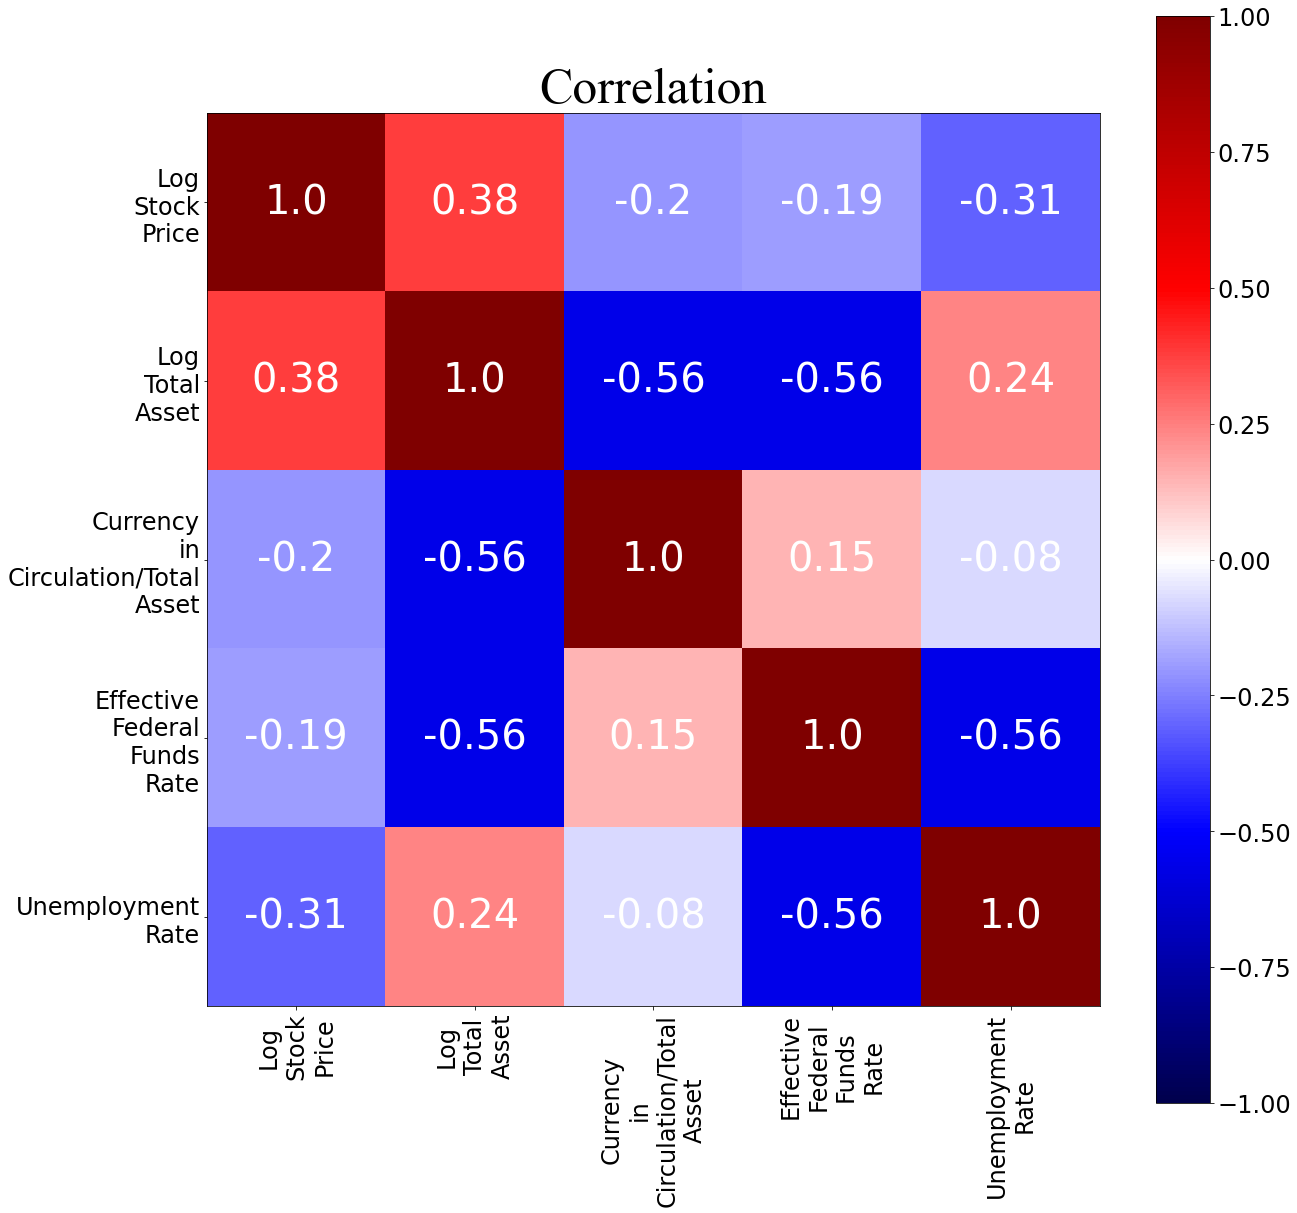

In [30]:
from datlib.plots import *
corr_matrix_heatmap(reg_data.corr())

In [31]:
reg_data.describe().round(2)

,Log Stock Price,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate
count,262.00,262.00,262.00,262.00,262.00
mean,7.38,12.71,0.52,1.65,5.97
std,0.42,5.05,2.34,1.89,1.95
min,6.60,0.00,0.00,0.05,3.50
25%,7.07,13.61,0.00,0.13,4.60
50%,7.25,14.68,0.00,1.01,5.45
75%,7.65,15.29,0.00,2.39,6.90
max,8.43,15.96,16.00,6.54,14.80


In [32]:
y = reg_data[y_var]
X = reg_data[x_vars]
X["Constant"]=1
results = sm.OLS(y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Log Stock Price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     37.71
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           8.20e-25
Time:                        18:10:16   Log-Likelihood:                -81.411
No. Observations:                 262   AIC:                             172.8
Df Residuals:                     257   BIC:                             190.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Log Total Asset                         0.0258      0.006      4.232      0.000       0.014       0.038
Currency in Circulation/Total Asset    -0.0042      0.011     -0.385      0.701      -0.026       0.017
Effective Federal Funds Rate           -0.0754      0.016     -4.713      0.000      -0.107      -0.044
Unemployment Rate                      -0.1238      0.013     -9.582      0.000      -0.149      -0.098
Constant                                7.9149      0.141     56.248      0.000       7.638       8.192
==============================================================================
Omnibus:                       47.332   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.752
Skew:                           0.917   Prob(JB):                     2.66e-21
Kurtosis:                       5.305   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
est.pvalues

const                                  0.009828
Effective Federal Funds Rate           0.762914
Log Total Asset                        0.490391
Currency in Circulation/Total Asset    0.164226
Unemployment Rate                      0.000266
dtype: float64

In [34]:
keys = ['Log Total Asset',
         'Currency in Circulation/Total Asset',
         'Effective Federal Funds Rate',
         'Unemployment Rate',
         'Log Stock Price']

keys = keys
reg_data = data_updated[keys].dropna()

In [35]:
reg_data

,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate,Log Stock Price
Date,,,,,
2/28/2009,-0.077786,0.000039,0.07,0.4,-0.116457
3/31/2009,0.053397,-0.000021,-0.04,0.3,0.081953
4/30/2009,0.067534,-0.000028,-0.03,0.4,0.089772
5/31/2009,0.005147,-0.000001,0.03,0.1,0.051721
6/30/2009,-0.036956,0.000017,0.03,0.0,0.000196
...,...,...,...,...,...
6/30/2021,0.020092,-0.000004,0.02,-0.5,0.021971
7/31/2021,0.020202,-0.000005,0.02,-0.2,0.022493
8/31/2021,0.012321,-0.000003,-0.01,-0.4,0.028578


## Residuals

In [36]:
import statsmodels.api as sm

residuals = {}
for y_var in reg_data.keys():
    X_vars = list(reg_data.keys())
    X_vars.remove(y_var)
    X = reg_data[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = reg_data[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [37]:
residuals

,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate,Log Stock Price
Date,,,,,
2/28/2009,0.025936,1.085385e-05,-0.033998,0.314607,-0.065708
3/31/2009,-0.010450,-4.648376e-06,0.051272,0.411219,0.049893
4/30/2009,-0.014651,-6.642536e-06,0.087640,0.580437,0.050235
5/31/2009,-0.002643,-9.785548e-07,0.026993,0.360677,0.041632
6/30/2009,0.003947,2.439208e-06,-0.049160,-0.094019,0.010875
...,...,...,...,...,...
6/30/2021,0.001716,4.044056e-07,0.012283,-0.120149,0.000153
7/31/2021,0.001734,3.081939e-07,0.031372,0.152518,0.005321
8/31/2021,-0.003713,-1.201827e-06,-0.031738,-0.400915,0.007428


In [38]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate,Log Stock Price
Log Total Asset,1.00,-0.96,-0.31,-0.36,-0.06
Currency in Circulation/Total Asset,-0.96,1.00,-0.13,-0.28,-0.11
Effective Federal Funds Rate,-0.31,-0.13,1.00,-0.68,-0.02
Unemployment Rate,-0.36,-0.28,-0.68,1.00,-0.29
Log Stock Price,-0.06,-0.11,-0.02,-0.29,1.00


In [39]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,Log Total Asset,Currency in Circulation/Total Asset,Effective Federal Funds Rate,Unemployment Rate,Log Stock Price
Log Total Asset,NaN,0.00,0.00,0.0,0.48
Currency in Circulation/Total Asset,0.00,NaN,0.12,0.0,0.16
Effective Federal Funds Rate,0.00,0.12,NaN,0.0,0.76
Unemployment Rate,0.00,0.00,0.00,NaN,0.00
Log Stock Price,0.48,0.16,0.76,0.0,NaN


In [50]:
import pingouin
from pgmpy.estimators import PC
c = PC(reg_data[keys].dropna())
max_cond_vars = len(keys) - 2

sig = 0.5
model = c.estimate(return_type = "dag", variant = "parallel",
                  significance_level = sig,
                  max_cond_vars = max_cond_vars, ci_test = "pearsonr")

edges = list(model.edges())
pcorr = reg_data.pcorr()
weights = {}

Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  4.16it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  3.84it/s]


In [51]:
edges

[('Currency in Circulation/Total Asset', 'Unemployment Rate'),
 ('Currency in Circulation/Total Asset', 'Log Total Asset'),
 ('Effective Federal Funds Rate', 'Unemployment Rate'),
 ('Effective Federal Funds Rate', 'Log Total Asset'),
 ('Effective Federal Funds Rate', 'Currency in Circulation/Total Asset'),
 ('Log Total Asset', 'Unemployment Rate'),
 ('Log Stock Price', 'Unemployment Rate')]

[('Currency in Circulation/Total Asset', 'Unemployment Rate'),
 ('Currency in Circulation/Total Asset', 'Log Total Asset'),
 ('Effective Federal Funds Rate', 'Unemployment Rate'),
 ('Effective Federal Funds Rate', 'Log Total Asset'),
 ('Effective Federal Funds Rate', 'Currency in Circulation/Total Asset'),
 ('Log Total Asset', 'Unemployment Rate'),
 ('Log Stock Price', 'Unemployment Rate')]

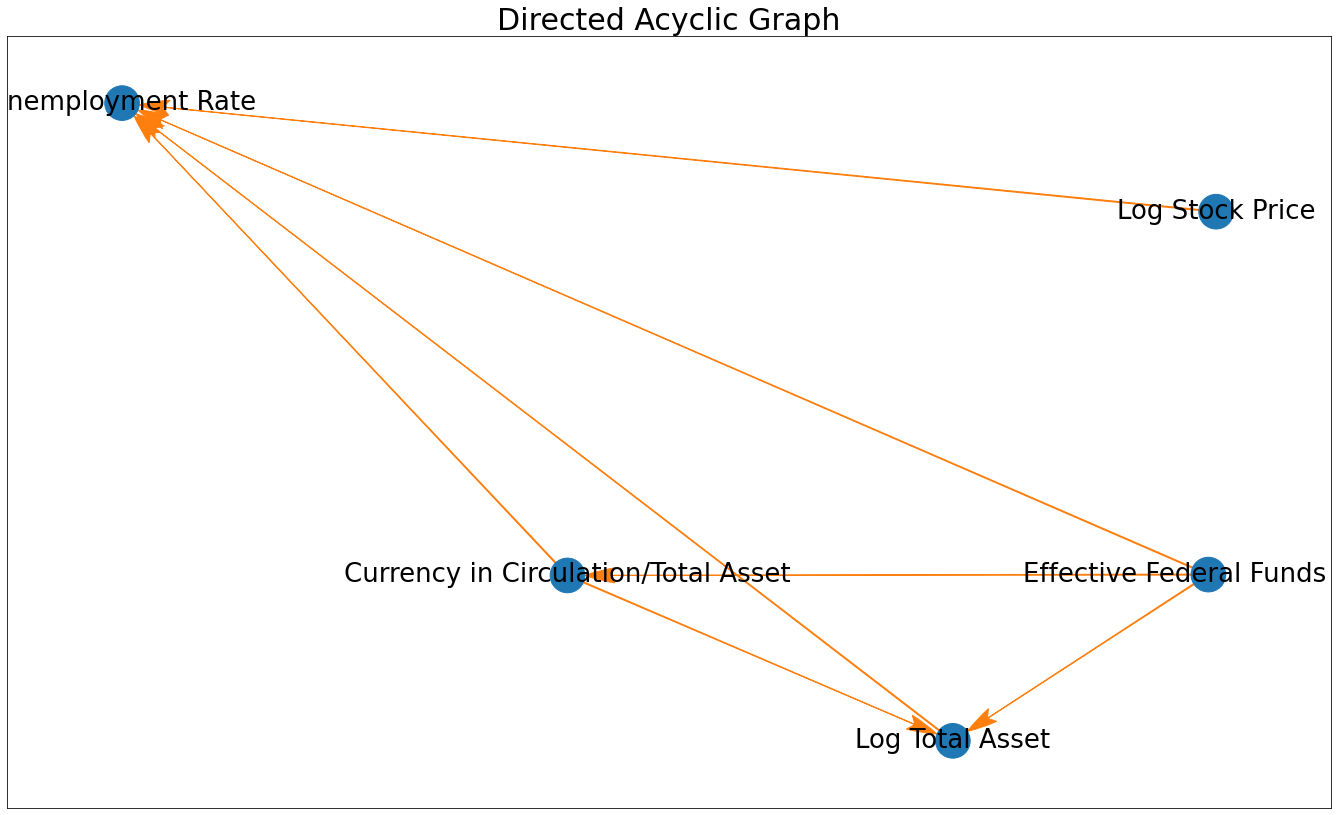

In [47]:
from matplotlib.patches import ArrowStyle
import networkx as nx
def graph_DAG(edges, reg_data, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, reg_data, title = "Directed Acyclic Graph")
edges

In [ ]:
from datlib.plots import *
corr_matrix_heatmap(data_updated.corr(), 
                    save_fig = False, 
                    pp = None, 
                    title = "Correlation")
corr_matrix_heatmap(data_updated.pcorr(), save_fig = False, pp = None, title = "Partial Correlation")

## Using partial correlations to build a causal skeleton

In [ ]:
undirected_graph = {key:[] for key in reg_data.keys()}
for x in undirected_graph:
    remaining_vars = [y for y in reg_data.keys() if y != x]
    for y in remaining_vars:
        undirected_graph[x].append(y)

undirected_graph

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
def graph_DAG(undirected_graph, reg_data, title = "DAG Structure"):
    
    # generate partial correlation matrix to draw values from
    # for graph edges
    pcorr_matrix = reg_data.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for edge in edges:
                edge_labels[edge] = str(round(pcorr_matrix[edge[0]].loc[edge[1]],2))

    # edge format: ("i", "j") --> from node i to node j
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  arrows=True,
                     arrowstyle = ArrowStyle("Fancy, head_length = 3, head_width = 1.5, tail_width = 1"),
                     font_size = 20, alpha = 1,
                     width = 1, edge_color = "C1",
                     font_color = "black",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
plt.close()
graph_DAG(edges, reg_data)
edges

In [ ]:
g1 = nx.DiGraph()
g1.add_edges_from(reg_data("Log Stock Price", "Log Total Asset"), ("Log Stock Price", "Unemployment Rate"), ("Log Stock Price", "Effective Federal Funds Rate"), ("Log Stock Price", "Currency in Circulation/Total Asset"))
plt.tight_layout()
nx.draw_networkx(g1, arrows=True)
plt.clf()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

edges = reg_data(('Effective Federal Funds Rate', 'Log Stock Price'), ('Log Stock Price', 'Log Total Asset'), ('Log Stock Price', 'Unemployment Rate'), ('Log Stock Price', 'Currency in Circulation/Total Asset'))
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={('Effective Federal Funds Rate', 'Log Stock Price'): 'AB', 
                 ('Log Stock Price', 'Log Total Asset'): 'BC', 
                 ('Log Stock Price', 'Unemployment Rate'): 'BD',
                 ('Log Stock Price', 'Currency in Circulation/Total Asset'): 'BE'},
    font_color='red'
)
plt.axis('off')
plt.show()


In [ ]:
from pgmpy.estimators import PC
c = PC(reg_data)
max_cond_vars = len(reg_data.keys()) - 2


model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()